In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy

# if you don't have gpu, 
# you can set device='cpu'
device = f'cuda:0'

* In this exercise, you will implement isometric representation learning algorithms for the hemisphere surface.   

1. For the hemisphere manifold $\mathcal{M}:=\{(x,y,z)\in\mathbb{R}^{3} | x^2+y^2+z^2=1, z>0\}$, we will consider a local coordinate system $f:\mathbb{R}^2 \to \mathcal{M}$ such that $f(x,y) = (x,y,\sqrt{1-x^2-y^2})$.

In [2]:
def local_coordinates_forward(z):
    '''
    z: torch.tensor whose size = (n, 2)
    '''
    return torch.cat([z, torch.sqrt(1-torch.norm(z, dim=1, keepdim=True)**2)], dim=1)
    
def local_coordinates_inverse(x):
    '''
    x: torch.tensor whose size = (n, 3)
    '''
    return x[:, :2]


* Let's visualize this coordinate system. 

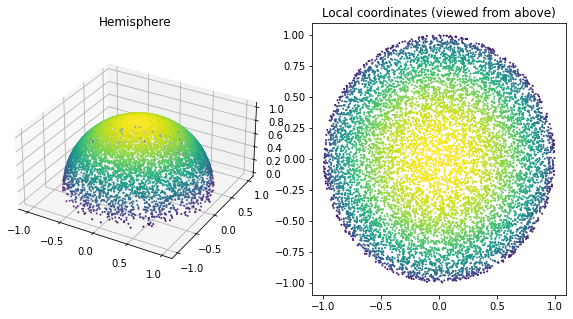

In [3]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)

def color_map(x):
    # return torch.arctan(x[:, 2]/torch.norm(x[:, :2], dim=1))
    return x[:, 2]

ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 2, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')
plt.show()

(a) Write the code for computing the Riemannian metric expressed in the above coordinate system.

In [4]:
def metric(z):
    '''
    z:      torch.tensor whose size = (n, 2)
    out:    torch.tensor whose size = (n, 2, 2)
    '''
    J = torch.cat(
        [
            torch.eye(2).unsqueeze(0).repeat(len(z), 1, 1).to(z), 
            - z.unsqueeze(1)/torch.sqrt(1 - torch.norm(z, dim=1, keepdim=True)**2).unsqueeze(1)
        ], dim=1)
    G = J.permute(0, 2, 1)@J
    return G

* Run the below code block to visualze the Riemannian metrics as equidistant ellipses.

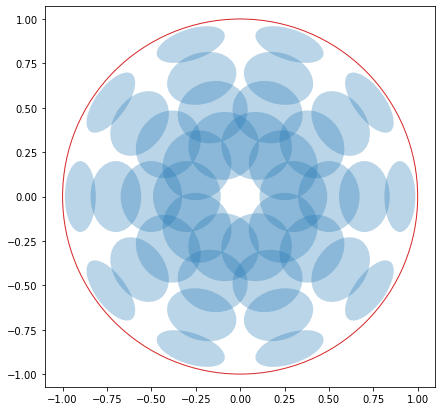

In [5]:
from utils import PD_metric_to_ellipse

points = []
for i in range(10):
    for j in range(4):
        theta = np.pi * 2 / 10 * i
        radius = 0.3 + 0.2 * j
        points.append([radius * np.cos(theta), radius * np.sin(theta)])
points = torch.Tensor(points)

G = metric(points)

# draw figures
f = plt.figure(figsize=(7,7))
ax = plt.gca()
for i, g in enumerate(G):
    e = PD_metric_to_ellipse(np.linalg.inv(g), points[i,:], 0.2, alpha = 0.3)
    ax.add_artist(e)
circle = plt.Circle((0, 0), 1, color='tab:red', fill=False)
ax.add_patch(circle)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
plt.axis('equal')
plt.show()

Q1) Interpret the result.

2. Now, you will find a near isometric mapping $f$ from the local cooridnate space $U:=\{z\in\mathbb{R}^2|z_1^2+z_2^2 < 1\}$ assigned with the above metric $G(z)$ to the Euclidean space $\mathbb{R}^2$ assigned with the identity metric. We will approximate the mapping $f$ with a fully-connected neural network.

* First of all, we will try to minimize the follwing loss function: $\int_U \sum_{i=1}^{2}(\lambda_i(J^T J G^{-1}) - 1)^2 \sqrt{\det(G)} \ dz$ where $\lambda_i(\cdot)$ denote the eigenvalues and $J$ is the Jacobian of $f$.
* To implement the integration, we will use the Monte-Carlo approximation with the uniform distribution on $U$.
* We will use one of the standard stochastic gradient decent methods.

* Define a fully-connected NN model as below (torch.nn.module class)

In [6]:
from models.modules import FC_vec
model = FC_vec(
    in_chan=2,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['relu', 'relu'],
    out_activation='linear',
).to(device);

In [7]:
model

FC_vec(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [8]:
z = torch.randn(10, 2).to(device)
out = model(z)
print(out.size())

torch.Size([10, 2])


* Below function can be used to compute the Jacobian of the above NN model.

In [9]:
def jacobian_of_f(f, z, create_graph=True):
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    out = (
        torch.autograd.functional.jvp(
            f, z, v=v, create_graph=create_graph
        )[1].view(batch_size, z_dim, -1).permute(0, 2, 1)
    )
    return out 

In [10]:
z = torch.randn(100, 2).to(device)
J = jacobian_of_f(model, z)
print(J.size())

torch.Size([100, 2, 2])


(b) Write the code for the follwing loss function: $\mathbb{E}_{z \sim p(z)} [\sum_{i=1}^{2}(\lambda_i(J^T J G^{-1}) - 1)^2 \sqrt{\det(G)}]$ where $p(z)$ is the uniform distribution on $U$. 

In [11]:
def isometry_loss(f, z_samples):
    '''
    f:          torch.nn.module class 
    z_samples:  torch.tensor whose size = (n, 2) 
    out:        torch.tensor whose size = (1, )
    '''
    J = jacobian_of_f(f, z_samples)
    G = metric(z_samples)
    pullback_metric = J.permute(0, 2, 1)@J@torch.linalg.inv(G)
    lambdas = torch.linalg.eigh(pullback_metric).eigenvalues
    detG = torch.linalg.det(G)
    losses = torch.sum((lambdas - 1)**2, dim=1) * torch.sqrt(detG)
    return losses.mean()

In [12]:
# samples from the uniform dist. p(z)
def randn_disk(num_samples, device):
    r = torch.sqrt(0.9999*torch.rand(num_samples, 1))
    theta = 2*np.pi*torch.rand(num_samples, 1)
    z_samples = torch.cat(
        [r*torch.cos(theta), r*torch.sin(theta)], dim=1).to(device)
    return z_samples

# monte-carlo estimation of the loss 
z_samples = randn_disk(1000, device)
isometry_loss(model, z_samples)

tensor(3.8020, device='cuda:0', grad_fn=<MeanBackward0>)

* Now you will minimize the above loss function by using torch autograd libs:  

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

l_losses = []
for epoch in range(300):
    z_samples = randn_disk(1000, device)
    optimizer.zero_grad()
    loss = isometry_loss(model, z_samples)
    l_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(loss.item())
isometry = copy.copy(model)

3.754411458969116
0.7431824207305908
0.6235851049423218


* Plot the loss curve:

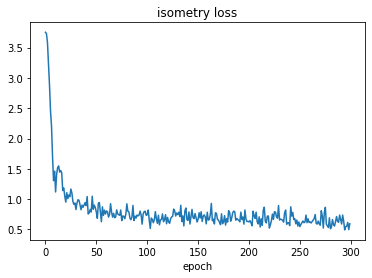

In [14]:
plt.title('isometry loss')
plt.xlabel('epoch')
plt.plot(l_losses)
plt.show()

* Compare the local coordinates and the isometric representation:

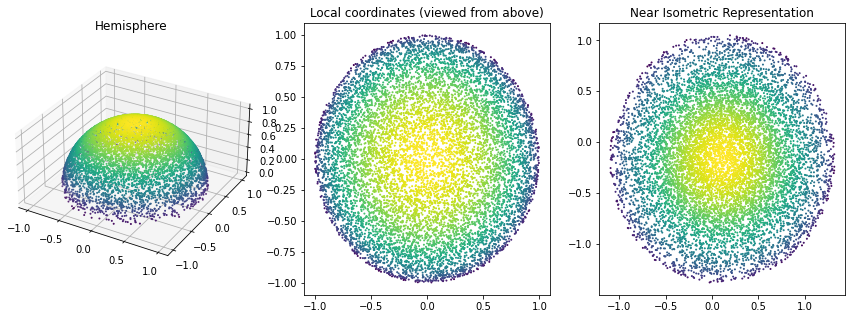

In [15]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 3, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')

ax = fig.add_subplot(1, 3, 3)
z_iso = isometry(z.to(device)).detach().cpu()
ax.scatter(z_iso[:, 0], z_iso[:, 1], c=color_map(x), s=1)
ax.set_title('Near Isometric Representation')

plt.show()

Q2) Interpret this result.

* Secondly, we will try to learn the harmonic map with the boundary condition that is $f(z)=z$ for $z\in\partial U:=\{(x,y)\in\mathbb{R}^2|x^2+y^2=1\}$.
* The harmonic loss function can be written as $\int_U \mathrm{Tr}(J^T J G^{-1})\sqrt{\det(G)} \ dz$ where $J$ is the Jacobian of $f$.
* To implement the integration, we will use the Monte-Carlo approximation with the uniform distribution on $U$ as the above.
* Again, we will use one of the standard stochastic gradient decent methods.

(c) Write the code for the follwing loss function: $\mathbb{E}_{z \sim p(z)} [\mathrm{Tr}(J^T J G^{-1})\sqrt{\det(G)}]$ where $p(z)$ is the uniform distribution on $U$. 

In [16]:
def harmonic_loss(f, z_samples):
    '''
    f:          torch.nn.module class 
    z_samples:  torch.tensor whose size = (n, 2) 
    out:        torch.tensor whose size = (1, )
    '''
    J = jacobian_of_f(f, z_samples)
    G = metric(z_samples)
    pullback_metric = J.permute(0, 2, 1)@J@torch.linalg.inv(G)
    lambdas = torch.linalg.eigh(pullback_metric).eigenvalues
    detG = torch.linalg.det(G)
    losses = torch.sum(lambdas, dim=1) * torch.sqrt(detG)
    return losses.mean()

(d) To make a neural network model satisfy the boundary condition, we need an additional loss term. Write the code for the boundary loss function.

In [17]:
def boundary_loss(f, z_boundary_samples):
    '''
    f:                   torch.nn.module class 
    z_boundary_samples:  torch.tensor whose size = (n, 2) 
    out:                 torch.tensor whose size = (1, )
    '''
    losses = torch.sum((f(z_boundary_samples) - z_boundary_samples)**2, dim=1)
    return losses.mean()

In [18]:
# samples from the uniform dist. p(z)
def randn_disk(num_samples, device):
    r = torch.sqrt(0.9999*torch.rand(num_samples, 1))
    theta = 2*np.pi*torch.rand(num_samples, 1)
    z_samples = torch.cat(
        [r*torch.cos(theta), r*torch.sin(theta)], dim=1).to(device)
    return z_samples

# samples from the uniform dist. on the boundary \partial U
def randn_boundary(num_samples, device):
    temp = torch.randn(num_samples, 2).to(device)
    z_boundary_samples = temp/torch.norm(temp, dim=1, keepdim=True)
    return z_boundary_samples

# monte-carlo estimation of the loss 
z_boundary_samples = randn_boundary(1000, device)
boundary_loss(model, z_boundary_samples)

tensor(2.4373, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
from models.modules import FC_vec
model2 = FC_vec(
    in_chan=2,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['relu', 'relu'],
    out_activation='linear',
).to(device);

* Now you will minimize the sum of the harmonic loss and boundary loss by using torch autograd libs:  

In [20]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

l_losses = []
for epoch in range(300):
    z_samples = randn_disk(1000, device)
    z_boundary_samples = randn_boundary(100, device)
    optimizer.zero_grad()
    h_loss = harmonic_loss(model2, z_samples)
    b_loss = boundary_loss(model2, z_boundary_samples)
    loss = h_loss + 100*b_loss
    l_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(loss.item())
harmonic_map = copy.copy(model2)

107.39997863769531
2.462519645690918
2.4129648208618164


* Plot the loss curve

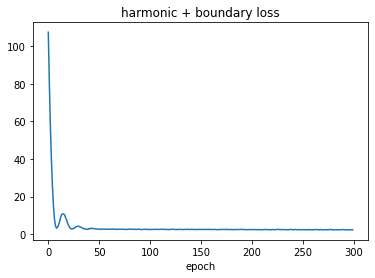

In [21]:
plt.title('harmonic + boundary loss')
plt.xlabel('epoch')
plt.plot(l_losses)
plt.show()

* Compare the local coordinates, the isometric representation, and the harmonic representation:

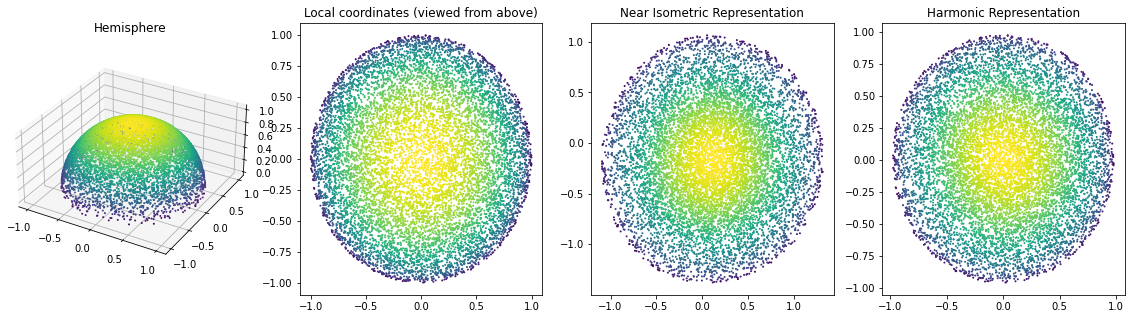

In [22]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 4, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 4, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')

ax = fig.add_subplot(1, 4, 3)
z_iso = isometry(z.to(device)).detach().cpu()
ax.scatter(z_iso[:, 0], z_iso[:, 1], c=color_map(x), s=1)
ax.set_title('Near Isometric Representation')

ax = fig.add_subplot(1, 4, 4)
z_harmonic = harmonic_map(z.to(device)).detach().cpu()
ax.scatter(z_harmonic[:, 0], z_harmonic[:, 1], c=color_map(x), s=1)
ax.set_title('Harmonic Representation')
plt.show()

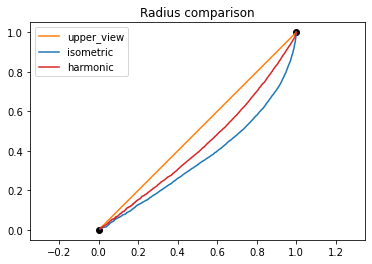

In [23]:
plt.title('Radius comparison')
r_upper_view = torch.norm(z, dim=1).sort(descending=True).values
r_iso = torch.norm(z_iso, dim=1).sort(descending=True).values
r_iso = r_iso/r_iso.max()
r_harmonic = torch.norm(z_harmonic, dim=1).sort(descending=True).values
r_harmonic = r_harmonic/r_harmonic.max()

plt.plot(r_upper_view, r_upper_view, c='tab:orange', label='upper_view')
plt.plot(r_upper_view, r_iso, c='tab:blue', label='isometric')
plt.plot(r_upper_view, r_harmonic, c='tab:red', label='harmonic')
plt.scatter([0, 1], [0, 1], c='k')

plt.axis('equal')
plt.legend()
plt.show()

Q3) How are they different? Compare and analyze the results.

3. Now, you are going to study how these types of geometry-preserving loss functions can be used for manifold representation learning problem. 

* As a simple toy case, we will consider the problem of learning a two-dimensional manifold of three-dimensional data points by using an autoencoder:

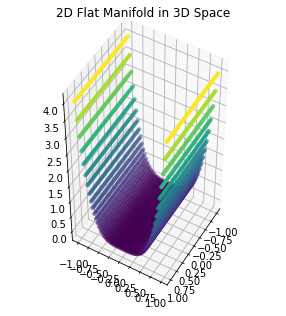

In [24]:
# 3D data generation 
X = torch.linspace(-1, 1, 60)
Y = torch.linspace(-1, 1, 60)
X, Y = torch.meshgrid(X, Y)
Z = 4*Y**4

x = torch.cat([
    X.reshape(-1, 1),
    Y.reshape(-1, 1),
    Z.reshape(-1, 1)
], dim=1)

def color_map2(x):
    return x[:, 2]

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map2(x), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('2D Flat Manifold in 3D Space')
ax.view_init(50, 30)

plt.show()


* Let's train an autoencoder with two-dimensional latent space:

In [25]:
# model define 
from models.ae import AE

encoder = FC_vec(
    in_chan=3,
    out_chan=2,
    l_hidden=[512, 512],
    activation=['relu', 'relu'],
    out_activation='linear',
)
decoder = FC_vec(
    in_chan=2,
    out_chan=3,
    l_hidden=[512, 512],
    activation=['relu', 'relu'],
    out_activation='linear',
)
ae = AE(encoder, decoder).to(device);

In [26]:
# train autoencoder
optimizer = torch.optim.Adam(ae.parameters(), lr=0.0001)

l_losses = []
for epoch in range(100):
    for batch in x.split(100):
        optimizer.zero_grad()
        recon = ae(batch.to(device))
        loss = ((recon - batch.to(device))**2).mean()
        l_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch%50 == 0:
        print(loss.item())

0.35121384263038635
0.005717405118048191


* Let's visaulize the result.

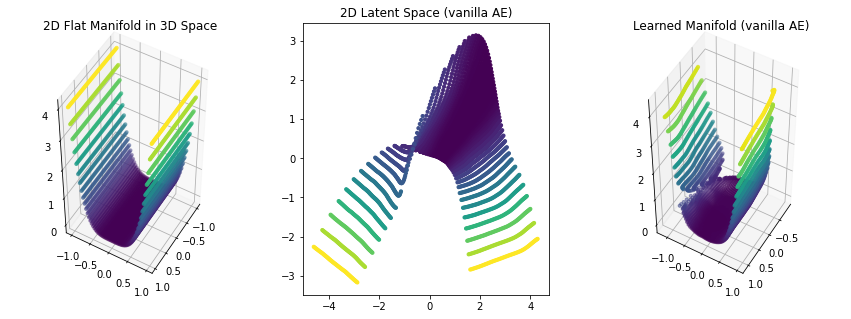

In [27]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map2(x), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('2D Flat Manifold in 3D Space')
ax.view_init(50, 30)

ax = fig.add_subplot(1, 3, 2)
ae_z = ae.encode(x.to(device)).detach().cpu()
ax.scatter(ae_z[:, 0], ae_z[:, 1], c=color_map2(x), s=10)
ax.set_title('2D Latent Space (vanilla AE)')

ax = fig.add_subplot(1, 3, 3, projection='3d')
recon = ae(x.to(device)).detach().cpu()
ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2], c=color_map2(recon), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Learned Manifold (vanilla AE)')
ax.view_init(50, 30)

plt.show()


Q4) Interpret the result.

* Now, let's train an autoencoder with two-dimensional latent space, but this time with the isometric regularization term.

In [28]:
# model define 
from models.ae import AE

encoder = FC_vec(
    in_chan=3,
    out_chan=2,
    l_hidden=[512, 512],
    activation=['relu', 'relu'],
    out_activation='linear',
)
decoder = FC_vec(
    in_chan=2,
    out_chan=3,
    l_hidden=[512, 512],
    activation=['relu', 'relu'],
    out_activation='linear',
)
irae = AE(encoder, decoder).to(device);

(e) Write the code for the isometry loss function for the decoder mapping $f:\mathbb{R}^{2} \to \mathbb{R}^{3}$ (assume both spaces $\mathbb{R}^{2}$ and $\mathbb{R}^3$ are assigned with the identity metrics).
* The loss term can be written as $\mathbb{E}_{z \sim p(z)}[\sum_{i=1}^{2} (\lambda_i(J^TJ)-1)^2] = \mathbb{E}_{z\sim p(z)}[\mathrm{Tr}((J^TJ)^2)-2 \ \mathrm{Tr}(J^TJ)+2]$ where $p(z)$ is the latent space data distribution and $J$ is the Jacobian of the decoder.
* To estimate the trace of $A$, you are recommened to use the Hutchinson’s Trace Estimator, i.e., $\mathrm{Tr}(A)\approx \mathbb{E}_{v \sim \mathcal{N}(0, 1)}[v^TAv]$ where $\mathcal{N}(0, 1)$ is the standard normal distribution. 
* Note that using one sample for $v \sim \mathcal{N}(0,1)$ is enough for the trace estimation in SGD-based NN training.

In [29]:
def decoder_isometry_loss(decoder, z):
    '''
    decoder:    torch.nn.module class 
    z:          torch.tensor whose size = (n, 2) 
    out:        torch.tensor whose size = (1, )
    '''
    bs = len(z)
    v = torch.randn(z.size()).to(z)
    Jv = torch.autograd.functional.jvp(decoder, z, v=v, create_graph=True)[1]
    TrG = torch.sum(Jv.view(bs, -1)**2, dim=1).mean()
    JTJv = (torch.autograd.functional.vjp(decoder, z, v=Jv, create_graph=True)[1]).view(bs, -1)
    TrG2 = torch.sum(JTJv**2, dim=1).mean()
    return TrG2 - 2*TrG + 2

In [30]:
# train autoencoder
optimizer = torch.optim.Adam(irae.parameters(), lr=0.0001)

l_losses = []
for epoch in range(200):
    for batch in x.split(100):
        optimizer.zero_grad()
        z_irae = irae.encode(batch.to(device))
        recon = irae.decode(z_irae)
        recon_loss = ((recon - batch.to(device))**2).mean()
        
        ### latent data augmentation ###
        # We want the isometric regularization effect to be applied for in-between data regions as well
        bs = len(z_irae)
        z_perm = z_irae[torch.randperm(bs)]
        alpha = torch.rand(bs).unsqueeze(1).to(device)
        z_augmented = alpha*z_irae + (1-alpha)*z_perm
        ################################
        
        iso_loss = decoder_isometry_loss(irae.decoder, z_irae)
        loss = recon_loss + 0.2*iso_loss
        l_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch%20 == 0:
        print(loss.item())

0.36467859148979187
0.051993176341056824
0.009969689883291721
0.05050940811634064
-0.001560100936330855
-0.021048251539468765
0.005922262091189623
-0.012948627583682537
0.0008965158485807478
0.025785740464925766


* Let's visualize the result.

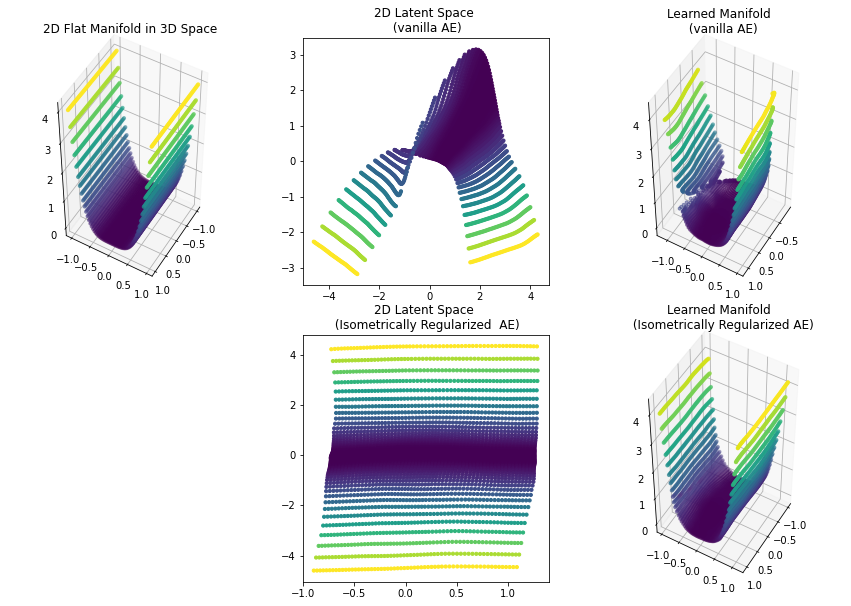

In [31]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map2(x), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('2D Flat Manifold in 3D Space')
ax.view_init(50, 30)

ax = fig.add_subplot(2, 3, 2)
ae_z = ae.encode(x.to(device)).detach().cpu()
ax.scatter(ae_z[:, 0], ae_z[:, 1], c=color_map2(x), s=10)
ax.set_title('2D Latent Space \n (vanilla AE)')

ax = fig.add_subplot(2, 3, 3, projection='3d')
recon = ae(x.to(device)).detach().cpu()
ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2], c=color_map2(recon), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Learned Manifold \n (vanilla AE)')
ax.view_init(50, 30)

ax = fig.add_subplot(2, 3, 5)
irae_z = irae.encode(x.to(device)).detach().cpu()
ax.scatter(irae_z[:, 0], irae_z[:, 1], c=color_map2(x), s=10)
ax.set_title('2D Latent Space \n (Isometrically Regularized  AE)')

ax = fig.add_subplot(2, 3, 6, projection='3d')
irae_recon = irae(x.to(device)).detach().cpu()
ax.scatter(irae_recon[:, 0], irae_recon[:, 1], irae_recon[:, 2], c=color_map2(recon), s=10)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Learned Manifold \n (Isometrically Regularized AE)')
ax.view_init(50, 30)

plt.show()


Q5) Interpret the results. Compare between the vanilla AE and isometrically regularized AE.

* You can find many more advanced usages of the isometric loss and harmonic loss functions.  
* One particular example usage in autoencoder representation learning can be found in the paper "Regularized Autoencoders for Isometric Representation Learning (ICLR 2022, Y.H. Lee et al.)". 
* For those who are interested in details, we include the git link: https://github.com/Gabe-YHLee/IRVAE-public. 